In [1]:
from utils import FishEyeImage, rot
from photutils.detection import find_peaks, DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.coordinates import angular_separation, position_angle
from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from astropy.io import fits
from astropy.table import Table, vstack
from matplotlib.collections import LineCollection
from astropy.coordinates import angular_separation, position_angle, offset_by, SkyCoord
# from photutils.aperture import CircularAperture
from astropy.stats import sigma_clipped_stats
# from photutils.detection import find_peaks
import tetra3
import rawpy
import exiftool
from photutils.detection import find_peaks, DAOStarFinder
import astropy.units as u
from scipy.optimize import minimize, curve_fit


2024-06-03 14:40:33,315:tetra3.Tetra3-INFO: Loading database from: c:\Users\mlang\anaconda3\Lib\site-packages\tetra3\data\default_database.npz


In [2]:

hips_star = Table.read('HIP2_rad.fits')

file = '010A7115'

pic = FishEyeImage(file+'.jpg', file+'.CR3')

solution = pic.solve(solve_size=1200)

pic.first_match(bin_size=5000)

{'RA': 49.38342492405408, 'Dec': 47.14395167785629, 'Roll': 304.86993414626215, 'FOV': 28.395137756530392, 'distortion': -0.011719679432878324, 'RMSE': 37.23127736140937, 'Matches': 25, 'Prob': 1.1616603334566845e-45, 'epoch_equinox': 2000, 'epoch_proper_motion': 2023.0, 'T_solve': 3.691100049763918, 'T_extract': 55.17500010319054}


c:\Users\mlang\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


(array([1950, 1920, 2100, ..., 2019, 2090, 1946], dtype=int64),
 <Angle [66.54863215,  1.23733013,  2.13818547, ..., 59.35663458,
          7.92971298, 68.44622104] deg>)

[0.8619033608361744, 0.8228171791796973, 5.3209841411905625, 14.6, -0.19]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 6.840272844191936
        x: [ 8.604e-01  8.226e-01  5.323e+00  1.457e+01 -1.411e-01]
      nit: 26
      jac: [ 6.279e-03 -1.158e-02 -5.770e-03 -7.540e-04 -4.082e-04]
     nfev: 186
     njev: 31
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


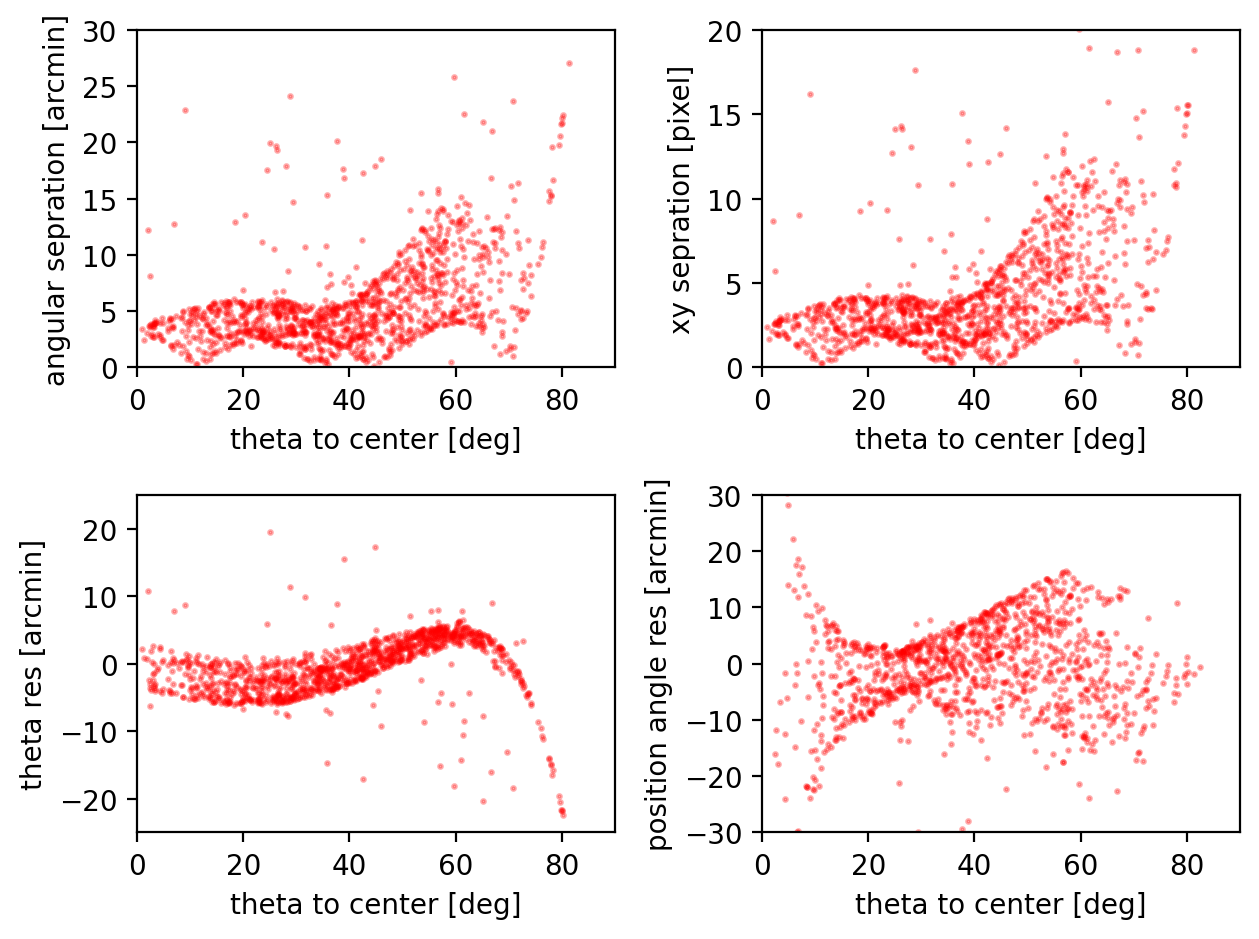

In [3]:
init , final = pic.lens_optimize(ra_dec_range=8, roll_range=8,f_range=2,k_range=0.2)
print(init)
print(final)
x = final.x
pic.ra=x[0]
pic.dec = x[1]
pic.roll = x[2]
pic.f=x[3]
pic.k=x[4]
pic.draw_residual(dpi=200, s=2, c = 'red',alpha=0.3)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 5.801299267883772
        x: [ 8.713e-01  8.254e-01  5.316e+00  2.996e+03  1.983e+03]
      nit: 22
      jac: [ 6.185e-03  2.603e-02  3.660e-02  3.771e-02 -9.954e-03]
     nfev: 168
     njev: 28
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


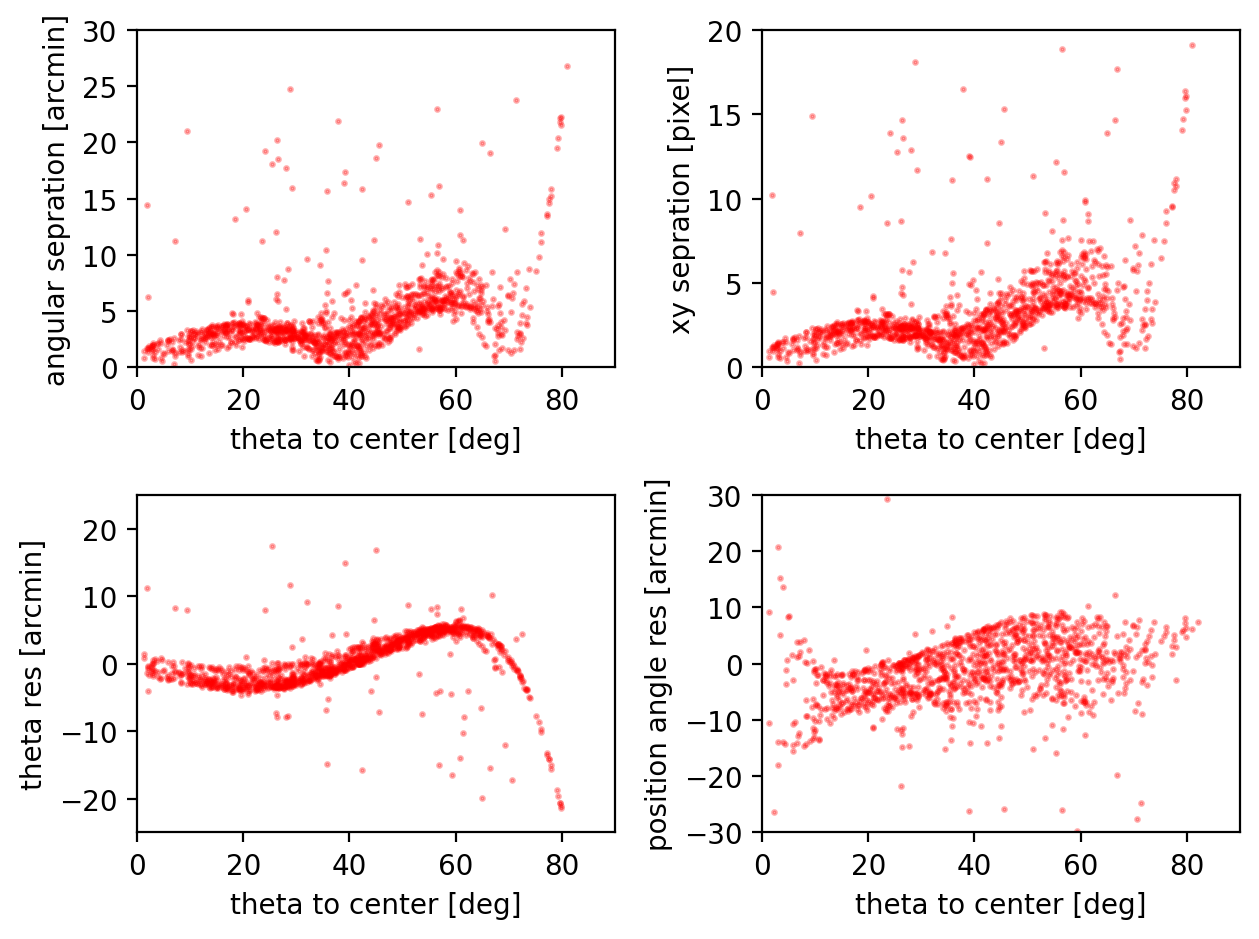

In [4]:
init , final = pic.plate_optimize(ra_dec_range=8, roll_range=8,c_xy_range=150)
print(final)
x= final.x
pic.ra=x[0]
pic.dec = x[1]
pic.roll = x[2]
pic.c_x =x[3]
pic.c_y =x[4]
pic.draw_residual(dpi=200, s=2, c = 'red',alpha=0.3)

In [5]:
catalog_x, catalog_y, catalog_theta, catalog_pa = pic.eq_to_xy(
            pic.ra*u.rad, pic.dec*u.rad, pic.matched_catalog_skycoords.ra, pic.matched_catalog_skycoords.dec)

(array([ 57., 111., 133., 179., 188., 187., 173., 120.,  64.,  18.]),
 array([ 1.29762033,  9.37682466, 17.45602899, 25.53523332, 33.61443764,
        41.69364197, 49.7728463 , 57.85205063, 65.93125496, 74.01045929,
        82.08966362]),
 <BarContainer object of 10 artists>)

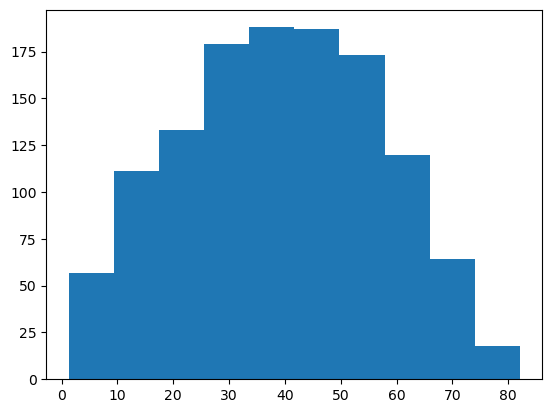

In [6]:
plt.hist(catalog_theta.to(u.deg))

(0.0, 23.0)

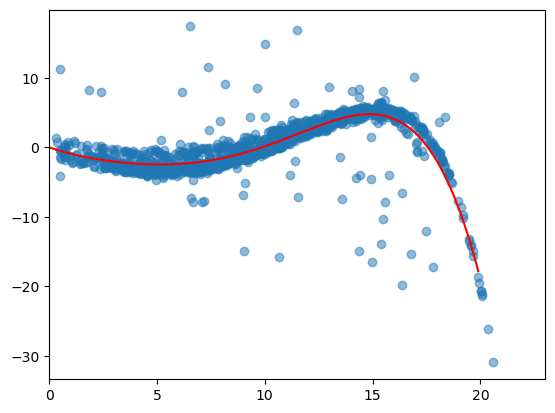

In [7]:
x  = pic.matched_stars_xy['xcentroid']
y =  pic.matched_stars_xy['ycentroid']
stars_ra, stars_dec, matched_stars_theta, matched_stars_pa = pic.xy_to_eq(
            pic.matched_stars_xy['xcentroid'], pic.matched_stars_xy['ycentroid'], c_ra=pic.ra, c_dec=pic.dec, roll=pic.roll, f=pic.f, k=pic.k,c_x=pic.c_x,c_y=pic.c_y)
delta_x = x - pic.c_x
delta_y = y - pic.c_y
delta_xy = np.asarray([delta_x, delta_y])
delta_xy = np.dot([[1, 0], [0, -1]], delta_xy)
# delta_xy = rot(delta_xy, -roll-np.pi/2)
r = np.sqrt(delta_x**2+delta_y**2)*pic.pixel_size
plt.scatter(r,matched_stars_theta-catalog_theta,alpha=0.5)

def func(r, a,b,c,d,e):
    return a*r**5+b*r**4+c*r**3+d*r**2+e*r

[a,b,c,d,e],_ = curve_fit(func,r,matched_stars_theta-catalog_theta)
rs  =np.arange(0,20,0.1)
plt.plot(rs,func(rs,a,b,c,d,e),c='red')
ax=plt.gca()
ax.set_xlim(0,23)

(-4.0, 4.0)

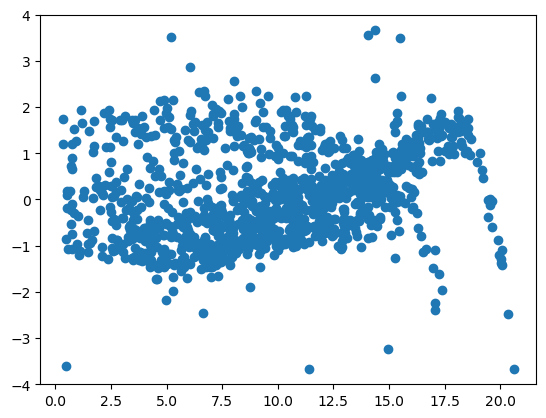

In [8]:
plt.scatter(r,(matched_stars_theta-catalog_theta)-func(r,a,b,c,d,e)*u.arcmin)
ax=plt.gca()
ax.set_ylim(-4,4)

In [9]:
pic.distort_optimize()

(-2.43634688482061e-08,
 6.873507956238557e-07,
 -6.577011481725718e-06,
 5.356947510134571e-05,
 -0.00031794962761822984)

In [10]:
[a,b,c,d,e]

[-8.375536686329112e-05,
 0.0023629346191510483,
 -0.022610043125781906,
 0.18415789835559754,
 -1.0930294073541564]

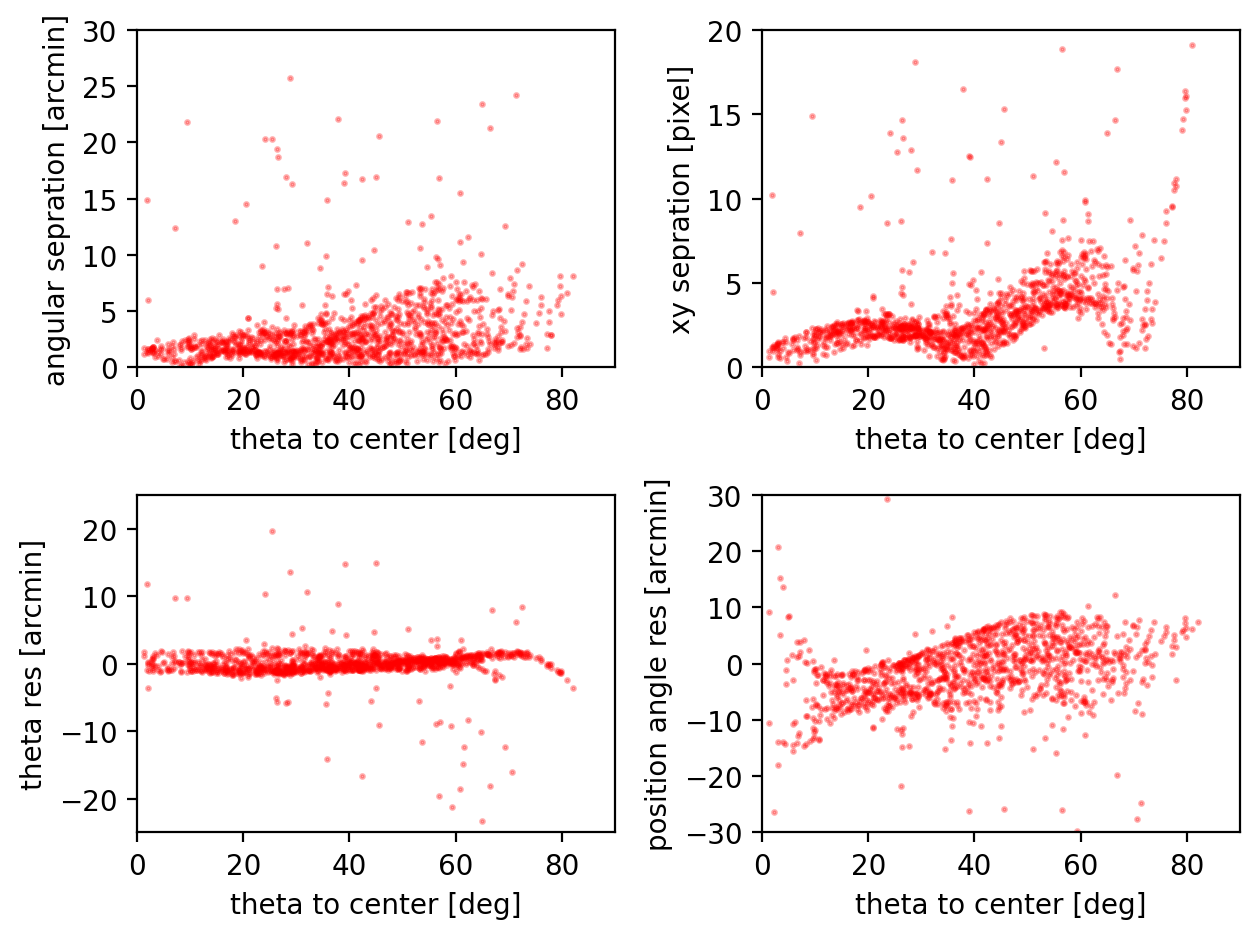

In [11]:
pic.distort_optimize()
pic.draw_residual_dis(dpi=200, s=2, c = 'red',alpha=0.3)

(-30.0, 30.0)

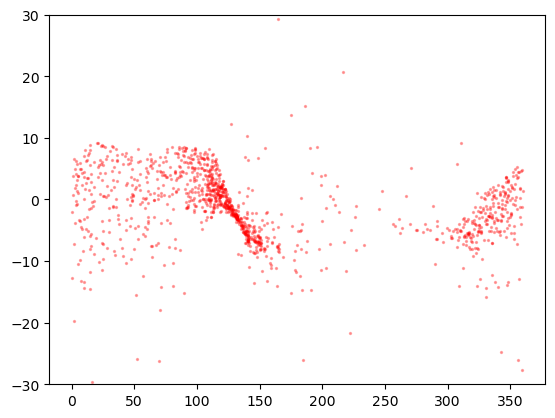

In [15]:
stars_ra, stars_dec, matched_stars_theta, matched_stars_pa = pic.xy_to_eq_distort(
    pic.matched_stars_xy['xcentroid'], pic.matched_stars_xy['ycentroid'])
stars_skycoords = SkyCoord(
    ra=stars_ra, dec=stars_dec, frame='icrs')
_, ang_sep, _ = pic.matched_catalog_skycoords.match_to_catalog_sky(
    stars_skycoords)

matched_stars_delta_x = pic.matched_stars_xy['xcentroid'] - pic.c_x
matched_stars_delta_y = pic.matched_stars_xy['ycentroid'] - pic.c_y
matched_stars_delta_xy = np.asarray(
    [matched_stars_delta_x, matched_stars_delta_y])
matched_stars_delta_xy = np.dot(
    [[1, 0], [0, -1]], matched_stars_delta_xy)
matched_stars_delta_xy = rot(
    matched_stars_delta_xy, -pic.roll-np.pi/2)
catalog_x, catalog_y, catalog_theta, catalog_pa = pic.eq_to_xy(
    pic.ra*u.rad, pic.dec*u.rad, pic.matched_catalog_skycoords.ra, pic.matched_catalog_skycoords.dec)
xy_sep = np.sqrt(
    (matched_stars_delta_xy[0]-catalog_x)**2+(matched_stars_delta_xy[1]-catalog_y)**2)

theta_rs = matched_stars_theta-catalog_theta
pa_rs = matched_stars_pa-catalog_pa
plt.scatter(catalog_pa.to(u.deg),pa_rs, s=2, c = 'red',alpha=0.3)
ax = plt.gca()
ax.set_ylim(-30,30)